In [18]:
import argparse
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os.path as osp
import pickle
from tqdm import tqdm
import random
from scipy.optimize import minimize
from scipy.stats import norm
import seaborn as sns

plt.rcParams['font.family'] = 'Times New Roman'


In [19]:
def get_recurrence_quantification(src, istime=False, min_ts=None, step=None, recur_matrix=None, color_dict=None):
    neighs, ts, eid  = ext_full_indices[src], ext_full_ts[src], ext_full_eid[src]
    intervals = []
    if not istime:
        recur_matrix = np.zeros((len(neighs), len(neighs)))
    else:
        pass
    for i in range(len(neighs)):
        for j in range(i+1, len(neighs)):
            if (neighs[j] == neighs[i]):
                idxi, idxj = (i, j) if not istime else (int((ts[i] - min_ts) // step), int((ts[j] - min_ts) // step))
                try:
                    recur_matrix[idxi][idxj] += 1
                except IndexError:
                    import pdb; pdb.set_trace()
    if not istime:
        return recur_matrix, np.sum(recur_matrix)

def tsort_original(i, indices, ts, eid):
    if not len(indices):
        return
    try:
        sidx = np.argsort(ts)
        indices = np.array(indices)[sidx]
        ts = np.array(ts)[sidx]
        eid = np.array(eid)[sidx]
    except TypeError:
        import pdb; pdb.set_trace()


In [20]:
parser = argparse.ArgumentParser()
parser.add_argument('--data', type=str, help='dataset name')
parser.add_argument('--all_data', action='store_true')
parser.add_argument('--add_reverse', default=False, action='store_true')
parser.add_argument('--bins', type=int, default=-1)
parser.add_argument('--fontsize', type=int, default=32, help='font size')
parser.add_argument('--file_path', type=str, default='')
args = parser.parse_args(args=['--all_data', '--bins', '1000'])
plt.rcParams['font.size'] = args.fontsize
print(args)

datasets = ['WIKI', 'REDDIT', 'Flights', 'LASTFM', 'mooc', 'uci', 'CollegeMsg']
show_datasets = {
    'WIKI': 'Wikipedia',
    'REDDIT': 'REDDIT',
    'Flights': 'Flights',
    'LASTFM': 'LASTFM',
    'mooc': 'MOOC',
    'uci': 'UCI',
    'CollegeMsg': 'CollegeMsg'
}
if not args.all_data:
    assert args.data in datasets
    datasets = [args.data,]
else:
    datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']

total_matrices = []

Namespace(data=None, all_data=True, add_reverse=False, bins=1000, fontsize=32, file_path='')


In [21]:
def norm_mat(recur_matrix):
    ma, mi, me = np.max(recur_matrix[recur_matrix > 1e-6]), np.min(recur_matrix[recur_matrix > 1e-6]), np.mean(recur_matrix[recur_matrix > 1e-6])
    p5 = np.percentile(recur_matrix[recur_matrix > 1e-6], 5)
    p95 = np.percentile(recur_matrix[recur_matrix > 1e-6], 95)
    # print(ma, mi, me, p5, p95)
    recur_matrix[(recur_matrix > p95)] = p95 - 0.1
    recur_matrix[(recur_matrix < p5) & (recur_matrix > 1e-6)] = p5 + 0.1
    scalar = p95 - p5
    return (recur_matrix - p5) / scalar

def _norm_mat(recur_matrix):
    N = recur_matrix.shape[0]
    return (recur_matrix) / N / N


In [22]:
for data in datasets:
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    else:
        assert not args.all_data, 'Prepare data!'
        print('sorting and analyzing...')
        ext_full_indptr = np.zeros(num_nodes + 1, dtype=np.int32)
        ext_full_indices = [[] for _ in range(num_nodes)]
        ext_full_ts = [[] for _ in range(num_nodes)]
        ext_full_eid = [[] for _ in range(num_nodes)]

        for idx, row in tqdm(df.iterrows(), total=len(df)):
            src = int(row[s])
            dst = int(row[d])
            
            ext_full_indices[src].append(dst)
            ext_full_ts[src].append(row[t])
            ext_full_eid[src].append(idx)
            
            if args.add_reverse:
                ext_full_indices[dst].append(src)
                ext_full_ts[dst].append(row[t])
                ext_full_eid[dst].append(idx)

        for i in tqdm(range(num_nodes)):
            ext_full_indptr[i + 1] = ext_full_indptr[i] + len(ext_full_indices[i])
        tmp = np.array(list(itertools.chain(*ext_full_ts)))
        min_ts = np.min(tmp)
        max_ts = np.max(tmp)
        print(f'Bins: {BINS}\t Time span: {min_ts} - {max_ts}')
        time_bins, step = np.linspace(min_ts, max_ts, BINS+1, retstep=True)
        recur_matrices = []
        color_dict = {}
        recur_matrix = np.zeros((BINS+1, BINS+1))
        for i in tqdm(range(num_nodes)):
            tsort_original(i, ext_full_indices[i], ext_full_ts[i], ext_full_eid[i])
            get_recurrence_quantification(i, True, min_ts, step, recur_matrix, color_dict)
        with open(args.file_path, 'wb') as f:
            all_data = {
                'indptr': ext_full_indptr,
                'indices': ext_full_indices,
                'ts': ext_full_ts,
                'eid': ext_full_eid,
                'recur': recur_matrix,
                'min_ts': min_ts,
                'step': step
            }
            pickle.dump(all_data, f)

    total_matrix = recur_matrix

    ma, mi, me = np.max(total_matrix[total_matrix > 1e-6]), np.min(total_matrix[total_matrix > 1e-6]), np.mean(total_matrix[total_matrix > 1e-6])
    p5 = np.percentile(total_matrix[total_matrix > 1e-6], 5)
    p95 = np.percentile(total_matrix[total_matrix > 1e-6], 95)
    print(ma, mi, me, p5, p95)
    scalar = p95 - p5

    total_matrix[(total_matrix > p95)] = p95 - 0.1
    total_matrix[(total_matrix < p5) & (total_matrix > 1e-6)] = p5 + 0.1

    total_matrices.append((total_matrix - p5) / scalar)


num_nodes:  9228
loading...
4.424115132732302e-05 1.0397920311958406e-06 3.946146215166472e-06 1.0597880317957604e-06 1.5395420761893413e-05
num_nodes:  1900
loading...
0.0027794383438739085 1.996005992009988e-06 1.7107769529450132e-05 1.996005992009988e-06 4.790414380823971e-05
num_nodes:  10985
loading...
0.006721550178093635 1.0978032956054935e-05 9.285330941896154e-05 4.391213182421974e-05 0.00017664653029288393
num_nodes:  13170
loading...
0.01253192362083471 0.0027614742899458185 0.004685398802323742 0.0034121722433410745 0.006572847731688891
num_nodes:  1980
loading...
0.38096868166798237 1.996005992009988e-06 0.0001658170530197533 2.994008988014982e-06 0.00036027908155780285
num_nodes:  7047
loading...
0.0025778417386808994 1.996005992009988e-06 1.2218730606897449e-05 1.996005992009988e-06 2.6946080892134837e-05


Plotting heatmap...
Saving...


/var/folders/g0/tq1p162j3s179yw_6h8mlbqr0000gn/T/ipykernel_79044/775596203.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


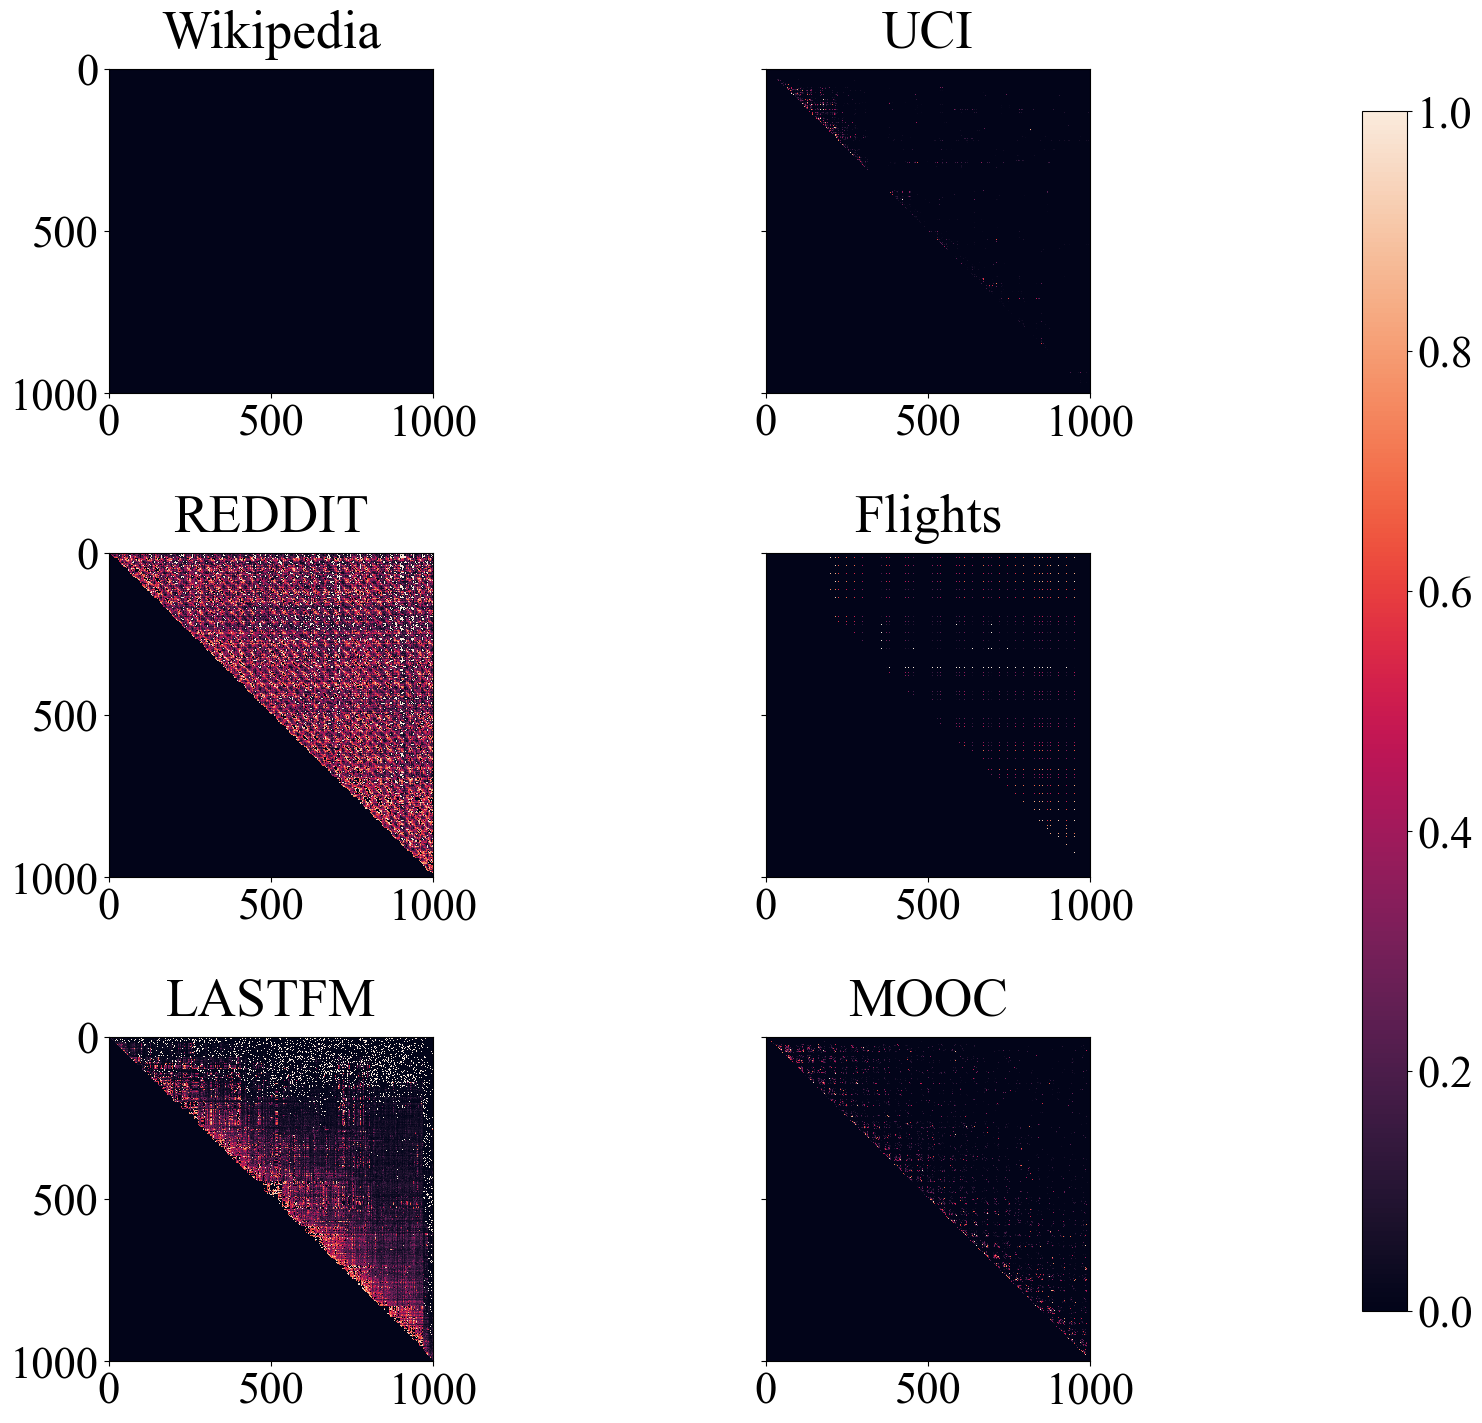

In [30]:
plt.rcParams['font.size'] = args.fontsize
fig, axes = plt.subplots(len(datasets)//2, 2, sharex=True, sharey=True, figsize=(15, 15))
cbar_ax = fig.add_axes([1.01, .1, .03, .8])
print('Plotting heatmap...')
for i, ax in enumerate(axes.flat):
    # sns.heatmap(total_matrices[i], vmin=0, vmax=1, ax=ax, cbar=(i==0), xticklabels=int(BINS/5), 
    #             yticklabels=int(BINS/5),square=True, cbar_ax=None if i else cbar_ax)
    im = ax.matshow(total_matrices[i], vmin=0, vmax=1, cmap='rocket',)
    ax.set_xticks(np.arange(0, BINS+1, BINS//2))
    ax.set_yticks(np.arange(0, BINS+1, BINS//2))
    ax.set_title(f'{show_datasets[datasets[i]]}', y=1.04)
    ax.xaxis.set_ticks_position('bottom')
fig.colorbar(im, cax=cbar_ax,)
print('Saving...')
fig.tight_layout()
plt.savefig(f'../figures/recurrence/all_recurrence_analysis.pdf',bbox_inches='tight')

In [36]:
def time_density(recur_matrix, alpha, l):
    denom = 0.
    numer = 0.
    N = recur_matrix.shape[0]
    for i in range(l):
        for j in range(l):
            denom += recur_matrix[i, j]
            numer += recur_matrix[i, j] * (alpha ** i)
    return numer/denom

In [40]:
TDs = {}
datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']


for data in datasets:
    TDs[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            # recur_matrix = norm_mat(all_data['recur'])
            recur_matrix = all_data['recur']
            min_ts, step = all_data['min_ts'], all_data['step']
    
    for alpha in np.arange(0.8, 1,0.01):
        TDs[data].append(time_density(recur_matrix, alpha, 500))
    print(data, TDs[data])


num_nodes:  9228
loading...
WIKI [0.0003227321705113583, 0.00036429946766648123, 0.00042196238301081275, 0.0005025872323693631, 0.0006161573409002454, 0.0007772621421361828, 0.0010073406252874171, 0.001338095565366361, 0.0018167574009375468, 0.0025143377107775715, 0.003538857572969167, 0.005057164331761748, 0.007332270879104556, 0.010790390430678337, 0.01614892779291626, 0.024681181989169184, 0.038825031215692245, 0.06380851575272634, 0.11320301714259191, 0.24042848548945564]
num_nodes:  1900
loading...
uci [0.0003227321705113583, 0.00036429946766648123, 0.00042196238301081275, 0.0005025872323693631, 0.0006161573409002454, 0.0007772621421361828, 0.0010073406252874171, 0.001338095565366361, 0.0018167574009375468, 0.0025143377107775715, 0.003538857572969167, 0.005057164331761748, 0.007332270879104556, 0.010790390430678337, 0.01614892779291626, 0.024681181989169184, 0.038825031215692245, 0.06380851575272634, 0.11320301714259191, 0.24042848548945564]
num_nodes:  10985
loading...
REDDIT [0.

In [24]:
def RR(recur_matrix, tau):
    N = recur_matrix.shape[0]
    RRt = 0
    for i in range(N-tau):
        assert i >= 0 and i < N
        assert i+tau >= 0 and i+tau < N
        RRt += recur_matrix[i, i+tau]
    RRt /= (N-tau)
    return RRt


num_nodes:  9228
loading...
WIKI 1 1.0722855321707036e-07
WIKI 2 7.609139162182489e-08
WIKI 3 6.238200187158142e-08
WIKI 4 5.3959398637992497e-08
WIKI 5 4.7831569662331285e-08
WIKI 6 4.326898458979961e-08
WIKI 7 3.9770912740132894e-08
WIKI 8 3.678939948261859e-08
WIKI 9 3.447468998546866e-08
WIKI 10 3.205744566201595e-08
WIKI 11 3.011910100373169e-08
WIKI 12 2.858273046010035e-08
WIKI 13 2.693293913403188e-08
WIKI 14 2.5505061944735166e-08
WIKI 15 2.4837812081053274e-08
WIKI 16 2.338540781227412e-08
WIKI 17 2.23052342429188e-08
WIKI 18 2.1088639919488197e-08
WIKI 19 2.030148948906862e-08
WIKI 20 1.9987986973789752e-08
WIKI 21 1.913044225731767e-08
WIKI 22 1.865845872193104e-08
WIKI 23 1.8235478799255175e-08
WIKI 24 1.724923114796115e-08
WIKI 25 1.697034273047525e-08
WIKI 26 1.66823776433616e-08
WIKI 27 1.6188861524398666e-08
WIKI 28 1.558096065997964e-08
WIKI 29 1.5410074670114735e-08
WIKI 30 1.499048284870142e-08
WIKI 31 1.4839559522448146e-08
WIKI 32 1.4218241574133079e-08
WIKI 33 1.

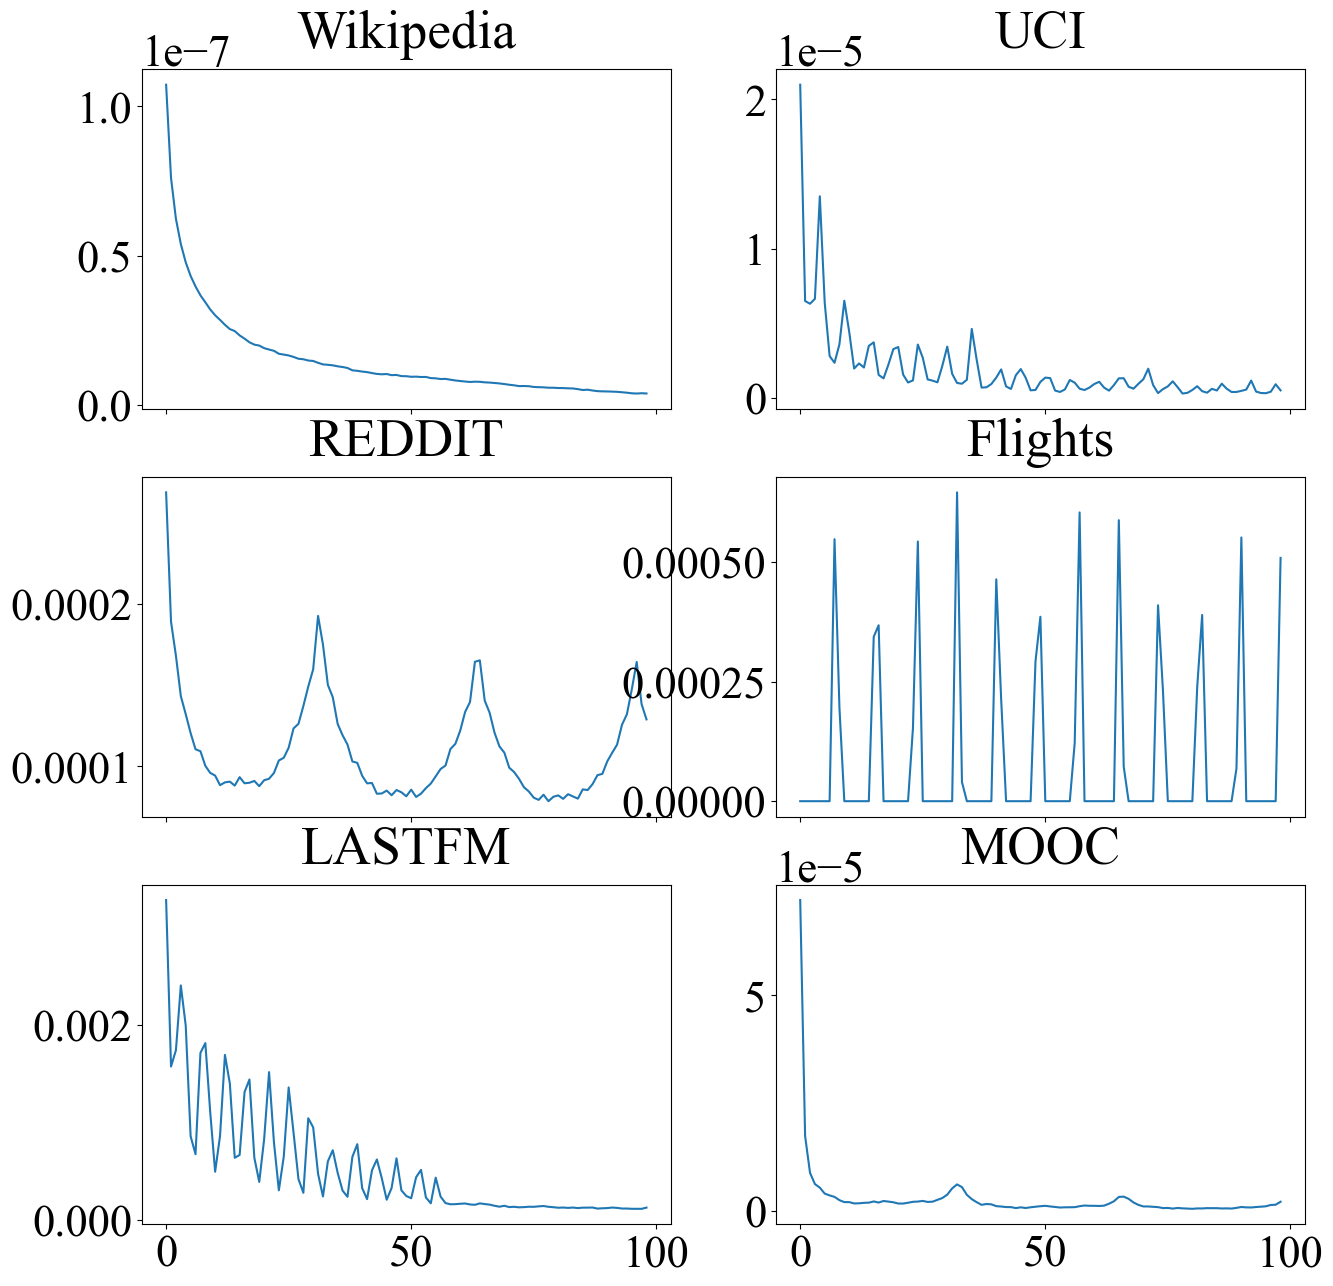

In [26]:
RRts = {}
datasets = ['WIKI', 'uci', 'REDDIT', 'Flights', 'LASTFM', 'mooc']


for data in datasets:
    RRts[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    for tau in range(1, 100):
        RRts[data].append(RR(recur_matrix, tau))
        print(data, tau, RRts[data][-1])
fig, axes = plt.subplots( len(datasets)//2,2, sharex=True, figsize=(15, 15))
print('Plotting RR...')
for i, ax in enumerate(axes.flat):
    ax.plot(RRts[datasets[i]])
    ax.set_title(f'{show_datasets[datasets[i]]}', y=1.04)


In [27]:
def TREND(RRt, N_tilde):
    RRt_mean = np.mean(RRt[:N_tilde])
    denom = np.sum([(tau - N_tilde)**2 for tau in range(N_tilde)])
    numer = np.sum([(tau - N_tilde)*(RRt[tau] - RRt_mean) for tau in range(N_tilde)])
    return numer/denom


In [28]:
RRt = [0.9, 0.5, 0.2, 0.1, 0.01]
# RRt = [0.9, 0.8, 0.5, 0.2, 0.1]
N = 5
print(TREND(RRt, N))
RRt = [0.9, 0.8, 0.7, 0.7, 0.7]
N = 5
print(TREND(RRt, N))

-0.03963636363636365
-0.00909090909090906


In [29]:
TRENDs = {}
N_tilde = 950
for i, data in enumerate(datasets):
    TRENDs[data] = []
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            min_ts, step = all_data['min_ts'], all_data['step']
    TRENDs[data]= TREND(RRts[data], N_tilde)
    print(data, TRENDs[data])
# fig, axes = plt.subplots(2, len(datasets)//2, sharex=True, figsize=(15, 15))
# print('Plotting TREND...')
# for i, ax in enumerate(axes.flat):
#     ax.plot(TRENDs[datasets[i]])

num_nodes:  9228
loading...


IndexError: list index out of range

In [ ]:
def P(recur_matrix, l, N_tilde):
    P = 0.0
    for i in range(1, N_tilde-l):
        for j in range(1, N_tilde-l):
            r = 1.0
            for k in range(l):
                r *= recur_matrix[i+k, j+k]
            P += r * (1-recur_matrix[i, j]) * (1-recur_matrix[i+l-1, j+l-1])
    return P 

def DETt(recur_matrix, lmin, tau):
    N = recur_matrix.shape[0]
    Pt = 0
    for i in range(N-tau):
        assert i >= 0 and i < N
        assert i+tau >= 0 and i+tau < N
        Pt += recur_matrix[i, i+tau]
    Pt /= (N-tau)
    return RRt

In [ ]:
for i, data in enumerate(datasets):
    df = pd.read_csv('../DATA/{}/edges.csv'.format(data))
    s = 'src' if 'src' in df.columns else 'u'
    d = 'dst' if 'dst' in df.columns else 'i'
    t = 'time' if 'time' in df.columns else 'ts'
    N_tilde = 100
    num_nodes = max(int(df[s].max()), int(df[d].max())) + 1
    print('num_nodes: ', num_nodes)
    # BINS = 1000 if data in ['uci', 'CollegeMsg'] else 10000
    BINS = int(min(10 ** int(np.log10(len(df)) - 1), 1e4)) if (args.bins == -1) else args.bins

    file_path = f'../figures/data/{data}_recur_time.pkl'
    if osp.exists(file_path):
        print('loading...')
        with open(file_path, 'rb') as f:
            all_data = pickle.load(f)
            ext_full_indptr, ext_full_indices, ext_full_ts, ext_full_eid = all_data['indptr'], \
            all_data['indices'], all_data['ts'], all_data['eid']
            recur_matrix = norm_mat(all_data['recur'])
            N = recur_matrix.shape[0]
            min_ts, step = all_data['min_ts'], all_data['step']
        DET = np.sum([l * P(recur_matrix, l, N_tilde) for l in range(30, N_tilde)]) / np.sum([l * P(recur_matrix, l, N_tilde) for l in range(N_tilde)])
        print(data, DET)

num_nodes:  9228
loading...
WIKI -6.944325829871986e-05
num_nodes:  1900
loading...
uci 2.1890988399038424e-20
num_nodes:  10985
loading...
REDDIT -0.06283950484765422
num_nodes:  13170
loading...
Flights -29.988945020299457
num_nodes:  1980
loading...
LASTFM 5.245832631394812e-09
num_nodes:  7047
loading...
mooc 0.0002019714305201565
